In [1]:
import numpy as np 
import pandas as pd
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/nlp-getting-started/sample_submission.csv
/kaggle/input/nlp-getting-started/train.csv
/kaggle/input/nlp-getting-started/test.csv


In [2]:
!pip install transformers

In [4]:
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup, BertForSequenceClassification
import torch
import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
%matplotlib inline
%config InlineBackend.figure_format='retina'


In [ ]:
train = pd.read_csv('../input/nlp-getting-started/train.csv')
test = pd.read_csv('../input/nlp-getting-started/test.csv')
submission = pd.read_csv('../input/nlp-getting-started/sample_submission.csv')

In [5]:
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 10, 6
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

In [7]:
train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [8]:
train['target'].value_counts() # Almost balanced dataset

0    4342
1    3271
Name: target, dtype: int64

In [10]:
PRE_TRAINED_MODEL_NAME = 'bert-base-uncased'
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [11]:
sample_txt = 'When was I last outside? I am stuck at home for 2 weeks.'
tokens = tokenizer.tokenize(sample_txt)
token_ids = tokenizer.convert_tokens_to_ids(tokens) # mapping each word to its index in the vocabolary.
print(f' Sentence: {sample_txt}')
print(f'   Tokens: {tokens}')
print(f'Token IDs: {token_ids}')

 Sentence: When was I last outside? I am stuck at home for 2 weeks.
   Tokens: ['when', 'was', 'i', 'last', 'outside', '?', 'i', 'am', 'stuck', 'at', 'home', 'for', '2', 'weeks', '.']
Token IDs: [2043, 2001, 1045, 2197, 2648, 1029, 1045, 2572, 5881, 2012, 2188, 2005, 1016, 3134, 1012]


**We will also add CLS token, to tell BERT that we are using it for classification.**

In [13]:
# All of that work can be done using the encode_plus() method
encoding = tokenizer.encode_plus(
  text=sample_txt,
  max_length=32,           # max length of sentence 
  add_special_tokens=True, # Add '[CLS]' and '[SEP]'
  return_token_type_ids=False,
  padding='max_length',
  return_attention_mask=True,
  return_tensors='pt',  # Return PyTorch tensors
)
encoding.keys()

dict_keys(['input_ids', 'attention_mask'])

In [14]:
# The token ids are now stored in a Tensor and padded to a length of 32
print(len(encoding['input_ids'][0]))
encoding['input_ids'][0]

32


tensor([ 101, 2043, 2001, 1045, 2197, 2648, 1029, 1045, 2572, 5881, 2012, 2188,
        2005, 1016, 3134, 1012,  102,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0])

In [15]:
# The attention mask has the same length:
print(len(encoding['attention_mask'][0]))
encoding['attention_mask']

32


tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0]])

In [16]:
# We can inverse the tokenization to have a look at the special tokens
print(tokenizer.convert_ids_to_tokens(encoding['input_ids'][0]))

['[CLS]', 'when', 'was', 'i', 'last', 'outside', '?', 'i', 'am', 'stuck', 'at', 'home', 'for', '2', 'weeks', '.', '[SEP]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]']


In [17]:
# Choosing max Sequence Length for our data set 
# BERT works with fixed-length sequences. We’ll use a simple strategy to choose the max length.
all_tweets = np.concatenate([train.text.values, test.text.values])

token_lens = []
for txt in all_tweets:
  tokens = tokenizer.encode(txt, max_length=512)
  token_lens.append(len(tokens))

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 0, 'Token count')

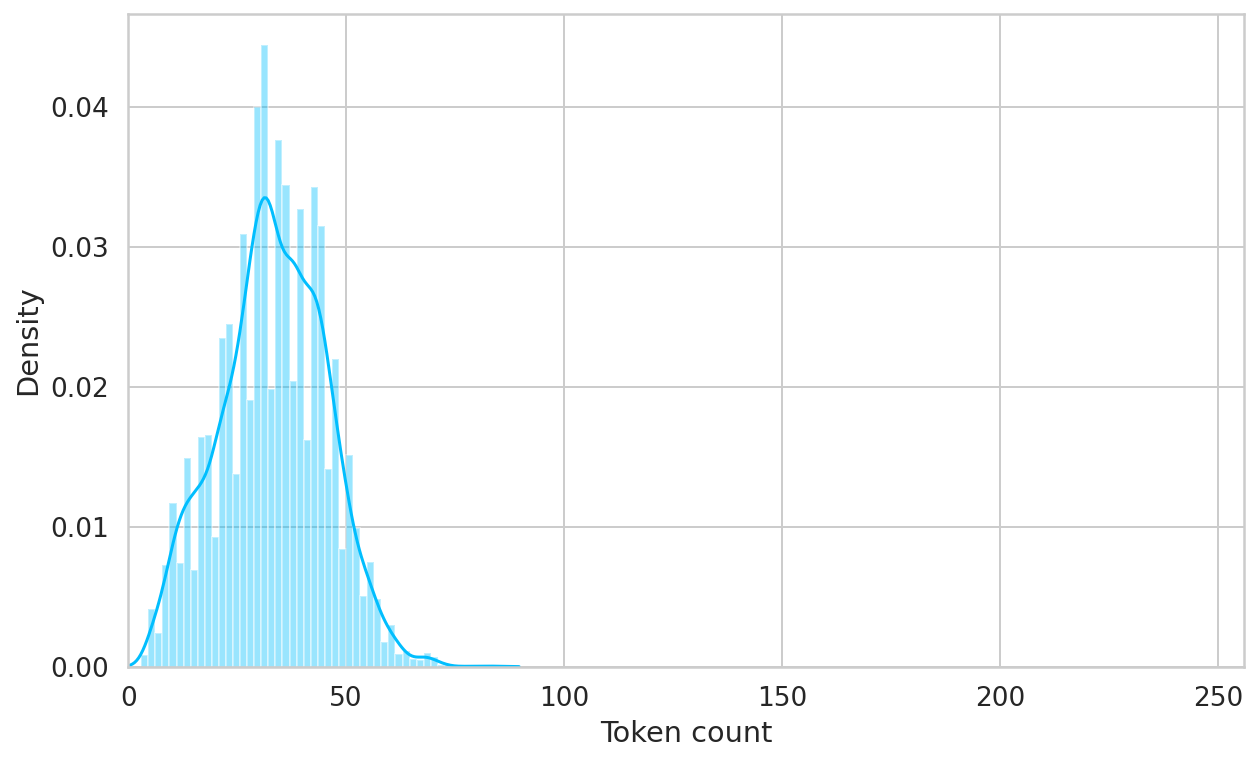

In [18]:
# plot the distribution
sns.distplot(token_lens)
plt.xlim([0, 256]);
plt.xlabel('Token count')

In [19]:
MAX_LEN = max(token_lens)
MAX_LEN

84

Create PyTorch dataset

In [20]:
class TweetDataset(Dataset):
  def __init__(self, text, targets, tokenizer, max_len):
    self.text = text
    self.targets = targets
    self.tokenizer = tokenizer
    self.max_len = max_len
    
  def __len__(self):
    return len(self.text)


  def __getitem__(self, item):
    text = str(self.text[item])
    target = self.targets[item]
    encoding = self.tokenizer.encode_plus(
      text,
      add_special_tokens=True,
      max_length=self.max_len,
      return_token_type_ids=False,
      padding='max_length',
      truncation=True,
      return_attention_mask=True,
      return_tensors='pt',
    )
    
    
    return {
      'text': text,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'targets': torch.tensor(target, dtype=torch.long)
    }

In [21]:
df_train, df_val = train_test_split(
  train,
  test_size=0.1,
  random_state=RANDOM_SEED
)

df_test = test
df_train.shape, df_val.shape, df_test.shape

((6851, 5), (762, 5), (3263, 4))

In [22]:
BATCH_SIZE = 16

In [23]:
def create_data_loader_train(df, tokenizer, max_len, batch_size):
  dataset = TweetDataset(
    text=df.text.to_numpy(),
    targets=df.target.to_numpy(),
    tokenizer=tokenizer,
    max_len=max_len
  )

  return DataLoader(
    dataset,
    batch_size=batch_size,
    num_workers=2
  )

In [24]:
class TweetDatasetTest(Dataset):
  def __init__(self, text, tokenizer, max_len):
    self.text = text
    self.tokenizer = tokenizer
    self.max_len = max_len
    
  def __len__(self):
    return len(self.text)


  def __getitem__(self, item):
    text = str(self.text[item])
    encoding = self.tokenizer.encode_plus(
      text,
      add_special_tokens=True,
      max_length=self.max_len,
      return_token_type_ids=False,
      padding='max_length',
      truncation=True,
      return_attention_mask=True,
      return_tensors='pt'
    )
    
    
    return {
      'text': text,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten()
    }

In [25]:
def create_data_loader_test(df, tokenizer, max_len, batch_size):
  dataset = TweetDatasetTest(
    text=df.text.to_numpy(),
    tokenizer=tokenizer,
    max_len=max_len
  )

  return DataLoader(
    dataset,
    batch_size=batch_size,
    num_workers=2
  )

In [26]:
CUSTOM_MAX_LEN = 60
train_data_loader = create_data_loader_train(df_train, tokenizer, CUSTOM_MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader_train(df_val, tokenizer, CUSTOM_MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader_test(df_test, tokenizer, CUSTOM_MAX_LEN, BATCH_SIZE)

In [27]:
import warnings
warnings.filterwarnings("ignore")
data = next(iter(train_data_loader))
data.keys()

dict_keys(['text', 'input_ids', 'attention_mask', 'targets'])

In [28]:
print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['targets'].shape)

torch.Size([16, 60])
torch.Size([16, 60])
torch.Size([16])


1. Currently the CUSTOM_MAX_LEN = 60, BATCH_SIZE = 16
2. So when, one item of train_data_loader is accessed using next iterator, we got the above shapes.

Bert Model

In [29]:
bert_model = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)

Downloading:   0%|          | 0.00/420M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [30]:
# return last state of encoder and pooled output 
# The last_hidden_state is a sequence of hidden states of the last layer of the model. 
# Obtaining the pooled_output is done by applying the BertPooler on last_hidden_state

# We have the hidden state for each of our 32 tokens (the length of our example sequence).
# 768 is the number of hidden units in the feedforward-networks

# https://huggingface.co/docs/transformers/model_doc/bert#bertmodel

# https://stackoverflow.com/questions/65132144/bertmodel-transformers-outputs-string-instead-of-tensor
output = bert_model(
  input_ids=encoding['input_ids'],
  attention_mask=encoding['attention_mask']
)

print(type(output))
print(output.keys())
print(bert_model.config.hidden_size)

<class 'transformers.modeling_outputs.BaseModelOutputWithPoolingAndCrossAttentions'>
odict_keys(['last_hidden_state', 'pooler_output'])
768


In [31]:
print(output['last_hidden_state'].shape)

torch.Size([1, 32, 768])


In [32]:
print(output['pooler_output'].shape)

torch.Size([1, 768])


Build Sentiment Classifier

In [33]:
import torch
import torch.nn as nn

# if torch.cuda.is_available():       
#     device = torch.device("cuda")
#     print(f'There are {torch.cuda.device_count()} GPU(s) available.')
#     print('Device name:', torch.cuda.get_device_name(0))

# else:
#     print('No GPU available, using the CPU instead.')
#     device = torch.device("cpu")

There are 1 GPU(s) available.
Device name: Tesla P100-PCIE-16GB


In [34]:
class SentimentClassifier(nn.Module):
  # while object creation, it expects number of classes and dropout percent.
  def __init__(self, n_classes, p):
    super(SentimentClassifier, self).__init__()
    self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
    self.drop = nn.Dropout(p)
    # torch.nn.Linear(in_features, out_features, bias=True, device=None, dtype=None)
    self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
    self.softmax = nn.Softmax(dim=1)
    

  # While prediction, it expects input_ids and attention_mask (from the tokenizer) so that I can feed it into BERT and extract 'pooler_output' which represent the entire sentence.  
  def forward(self, input_ids, attention_mask):
    output_dict = self.bert(
      input_ids=input_ids,
      attention_mask=attention_mask
    )
    output = self.drop(output_dict['pooler_output'])
    output = self.out(output)
    return self.softmax(output)

In [35]:
N_CLASSES = 2
P = 0.2
model = SentimentClassifier(N_CLASSES, P)
model = model.to(device)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [36]:
# data = next(iter(train_data_loader))
print(len(data['text']))
# data is consisted of 16 tweets 

16


In [37]:
input_ids = data['input_ids'].to(device)
attention_mask = data['attention_mask'].to(device)

In [38]:
print(input_ids.shape)
print(attention_mask.shape)

torch.Size([16, 60])
torch.Size([16, 60])


*batch_size X max_sentence_len*

In [39]:
input_ids[0]

tensor([  101,  1005, 11338,  7011, 17101,  7283,  2000,  3231, 10654,  3367,
         4892,  9432,  1005,  3081,  1030,  2780, 25379,  8299,  1024,  1013,
         1013,  1056,  1012,  2522,  1013,  1046,  2860,  4160,  2549,  2243,
         2615,  3501,  2232,  2475,  3501,   102,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0],
       device='cuda:0')

In [40]:
attention_mask[0]

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')

In [41]:
print(tokenizer.convert_ids_to_tokens(input_ids[0]))

['[CLS]', "'", 'mc', '##fa', '##dden', 'reportedly', 'to', 'test', 'ham', '##st', '##ring', 'thursday', "'", 'via', '@', 'teams', '##tream', 'http', ':', '/', '/', 't', '.', 'co', '/', 'j', '##w', '##q', '##4', '##k', '##v', '##j', '##h', '##2', '##j', '[SEP]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]']


In [42]:
# inject input ids and attention mask into Sentiment Classifier 
# this returns the probablity for 0 or 1 for each tweet in data 
model(input_ids, attention_mask)

tensor([[0.5732, 0.4268],
        [0.5262, 0.4738],
        [0.5411, 0.4589],
        [0.4822, 0.5178],
        [0.5069, 0.4931],
        [0.4379, 0.5621],
        [0.5686, 0.4314],
        [0.4946, 0.5054],
        [0.3939, 0.6061],
        [0.5367, 0.4633],
        [0.2105, 0.7895],
        [0.4452, 0.5548],
        [0.4793, 0.5207],
        [0.6908, 0.3092],
        [0.5844, 0.4156],
        [0.5893, 0.4107]], device='cuda:0', grad_fn=<SoftmaxBackward>)

Train Model 

AdamW optimizer corrects weight decay, so it’s similar to the original paper. We’ll also use a linear scheduler with no warmup steps

In [43]:
EPOCHS = 10
optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)
loss_fn = nn.CrossEntropyLoss().to(device)

How do we come up with all hyperparameters? The BERT authors have some recommendations for fine-tuning:

* Batch size: 16, 32
* Learning rate (Adam): 5e-5, 3e-5, 2e-5
* Number of epochs: 2, 3, 4

In [44]:
def train_epoch(
      model,
      data_loader,
      loss_fn,
      optimizer,
      device,
      scheduler,
      n_examples
):
      model = model.train()
      losses = []
      correct_predictions = 0
        
      for data in data_loader:
            input_ids = data["input_ids"].to(device)
            attention_mask = data["attention_mask"].to(device)
            targets = data["targets"].to(device)

            # inject inputs ids and attention mask into bert model 
            outputs = model(
              input_ids=input_ids,
              attention_mask=attention_mask
            )

            # return prediction 
            _, preds = torch.max(outputs, dim=1)

            # calculate loss 
            loss = loss_fn(outputs, targets)

            # calculate correct prediction 
            correct_predictions += torch.sum(preds == targets)
            
            # append each loss
            losses.append(loss.item())
            
            # back propagation 
            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            
            # updata parameters 
            optimizer.step()
            scheduler.step()
            optimizer.zero_grad()
            
      return correct_predictions.double() / n_examples, np.mean(losses)

Training the model should look familiar, except for two things.

The scheduler gets called every time a batch is fed to the model. 

We’re avoiding exploding gradients by clipping the gradients of the model using clipgrad_norm.

In [45]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()
  losses = []
  correct_predictions = 0
  with torch.no_grad():
    for data in data_loader:
      input_ids = data["input_ids"].to(device)
      attention_mask = data["attention_mask"].to(device)
      targets = data["targets"].to(device)
      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
        
      _, preds = torch.max(outputs, dim=1)
      loss = loss_fn(outputs, targets)
      correct_predictions += torch.sum(preds == targets)
      losses.append(loss.item())
        
  return correct_predictions.double() / n_examples, np.mean(losses)

In [46]:
%%time
history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):
    print(f'Epoch {epoch + 1}/{EPOCHS}')
    print('-' * 10)
    
    train_acc, train_loss = train_epoch(
                            model,
                            train_data_loader,
                            loss_fn,
                            optimizer,
                            device,
                            scheduler,
                            len(df_train)
                        )
    
    print(f'Train loss {train_loss} accuracy {train_acc}')
    
    val_acc, val_loss = eval_model(
                            model,
                            val_data_loader,
                            loss_fn,
                            device,
                            len(df_val)
                        )
    
    print(f'Val   loss {val_loss} accuracy {val_acc}')
    print()
    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)
    history['val_acc'].append(val_acc)
    history['val_loss'].append(val_loss)
    
    if val_acc > best_accuracy:
        torch.save(model.state_dict(), 'best_model_state.bin')
        best_accuracy = val_acc

Epoch 1/10
----------
Train loss 0.5332319058460512 accuracy 0.7740475842942636
Val   loss 0.5404201795657476 accuracy 0.7703412073490814

Epoch 2/10
----------
Train loss 0.4891997522963233 accuracy 0.821923806743541
Val   loss 0.5060865661750237 accuracy 0.8031496062992126

Epoch 3/10
----------
Train loss 0.46401930126276886 accuracy 0.8483433075463436
Val   loss 0.5006448943167925 accuracy 0.8097112860892388

Epoch 4/10
----------
Train loss 0.44524787411545264 accuracy 0.8671726755218215
Val   loss 0.501984354108572 accuracy 0.8110236220472441

Epoch 5/10
----------
Train loss 0.43183300531271734 accuracy 0.8816231207123048
Val   loss 0.49069193316002685 accuracy 0.8202099737532809

Epoch 6/10
----------
Train loss 0.4226236865098104 accuracy 0.890818858560794
Val   loss 0.49838398210704327 accuracy 0.8136482939632546

Epoch 7/10
----------
Train loss 0.4229022120679175 accuracy 0.8903809662822945
Val   loss 0.49802418425679207 accuracy 0.8136482939632546

Epoch 8/10
----------
Tr

(0.0, 1.0)

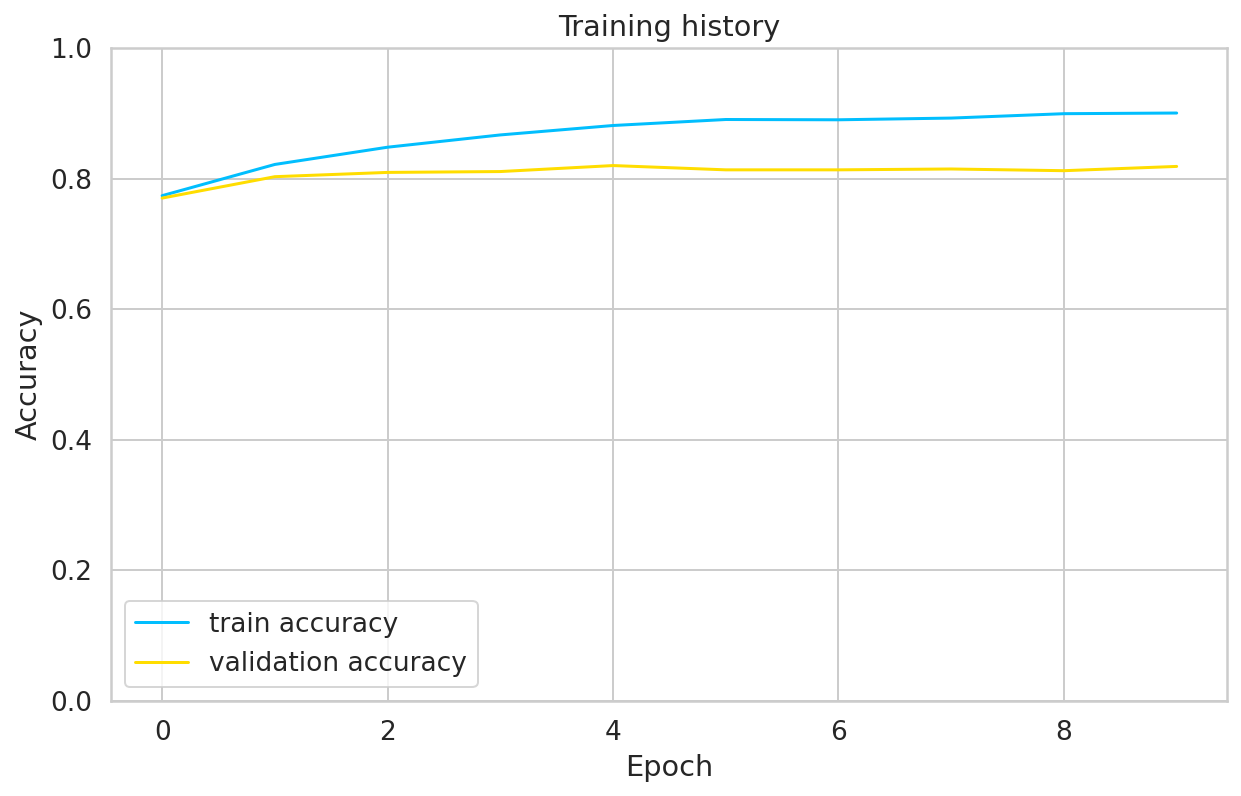

In [47]:
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')
plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1])

Predictions

In [48]:
test_data = next(iter(test_data_loader))
print(test_data['text'])

['Just happened a terrible car crash', 'Heard about #earthquake is different cities, stay safe everyone.', 'there is a forest fire at spot pond, geese are fleeing across the street, I cannot save them all', 'Apocalypse lighting. #Spokane #wildfires', 'Typhoon Soudelor kills 28 in China and Taiwan', "We're shaking...It's an earthquake", "They'd probably still show more life than Arsenal did yesterday, eh? EH?", 'Hey! How are you?', 'What a nice hat?', 'Fuck off!', "No I don't like cold!", "NOOOOOOOOO! Don't do that!", "No don't tell me that!", 'What if?!', 'Awesome!', "Birmingham Wholesale Market is ablaze BBC News - Fire breaks out at Birmingham's Wholesale Market http://t.co/irWqCEZWEU"]


In [49]:
print(test_data['input_ids'])

tensor([[  101,  2074,  3047,  1037,  6659,  2482,  5823,   102,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0],
        [  101,  2657,  2055,  1001,  8372,  2003,  2367,  3655,  1010,  2994,
          3647,  3071,  1012,   102,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0],
        [  101,  2045,  2003,  1037,  3224,  2543,

In [50]:
print(test_data['attention_mask'])

tensor([[1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
      

In [51]:
def get_predictions(model, data_loader):
  model = model.eval()
  tweets = []
  predictions = []
  prediction_probs = []
  
  with torch.no_grad():
    for data in data_loader:
      texts = data["text"]
      input_ids = data["input_ids"].to(device)
      attention_mask = data["attention_mask"].to(device)
      
      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
    
      _, preds = torch.max(outputs, dim=1)
      tweets.extend(texts)
      predictions.extend(preds)
      prediction_probs.extend(outputs)
      
  predictions = torch.stack(predictions).cpu()
  prediction_probs = torch.stack(prediction_probs).cpu()
  
  return tweets, predictions, prediction_probs

In [52]:
_, y_pred, _ = get_predictions(model, test_data_loader)

In [53]:
print(len(y_pred.tolist()))

3263


In [54]:
submission['target'] = y_pred.tolist()
submission.head()

,id,target
0,0,0
1,2,1
2,3,1
3,9,1
4,11,1


In [55]:
submission.to_csv('submission.csv', index=False)